In [1]:
import argparse
import json
from pathlib import Path
import random
import os
import schedulefree

import numpy as np
import torch
import wandb

import config
from data.utils import DataReader, get_dataset
import distributed
from models.utils import get_model
from optim.base import train
from optim.utils import cos_inf_schedule, wsd_schedule, get_batch

import sys

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]
    
def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument(
        "--config_format", default="base", choices=config.registered_formats()
    )
    args, rem_args = parser.parse_known_args()
    args.n_layer=8
    args.n_head=6
    args.n_embd=384
    args.datasets_dir = "/chenyupeng/data_files/llm_datasets"
    return config.parse_args_with_format(
        format=args.config_format, base_parser=parser, args=rem_args, namespace=args
    )

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = get_args()

In [3]:
args.config_format

'base'

In [4]:
import copy

In [5]:

def get_data_readers(args, verbose=True):
    data_srcs = get_dataset(args)
    train_reader = DataReader(
        data_src=data_srcs["train"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=True,
        keep_in_ram=args.data_in_ram,
    )
    val_reader = DataReader(
        data_src=data_srcs["val"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=False,  # NOTE Identical Per Rank
        keep_in_ram=args.data_in_ram,
    )

    if verbose:
        print(f"Num training tokens: {train_reader.num_tokens}")
        print(f"Num validation tokens: {val_reader.num_tokens}")

    return {
        "train": train_reader,
        "val": val_reader,
    }
data = get_data_readers(args)

/chenyupeng/data_files/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563


In [7]:
x_train, y_train = get_batch(data["train"], device="cpu")

In [8]:
x, y = get_batch(data["val"], device="cpu")

In [9]:
x_2, y_2 = get_batch(data["val"], device="cpu")

In [6]:
model = get_model(args)

In [22]:
current_ckpt1 = torch.load(f"/chenyupeng/old_files/yupeng_gpt/WSD/river_valley_project/llama_33m/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup300_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{11000}/main.pt",map_location=torch.device('cpu'))
current_ckpt2 = torch.load(f"/chenyupeng/old_files/yupeng_gpt/WSD/river_valley_project/llama_33m/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup300_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{12000}/main.pt",map_location=torch.device('cpu'))
current_ckpt3 = torch.load(f"/chenyupeng/old_files/yupeng_gpt/WSD/river_valley_project/llama_33m/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup300_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{13000}/main.pt",map_location=torch.device('cpu'))
import copy
current_ckpt4 = copy.deepcopy(current_ckpt3)

In [21]:
for i in range(len(current_ckpt1['optimizer']['state'])):
    current_ckpt4['optimizer']['state']["evp_avg"] = current_ckpt3

58

In [27]:
for k,v in current_ckpt1['optimizer']['state'][4].items():
    print(k)

step
exp_avg
exp_avg_sq


In [25]:
for a,b in current_ckpt4['optimizer']['state'].items():
    print(a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


In [24]:
current_ckpt4["model"]

OrderedDict([('_orig_mod.transformer.wte.weight',
              tensor([[ 3.9892e-02,  3.0132e-02, -2.0824e-01,  ...,  2.7212e-02,
                        1.2312e-01,  4.3065e-02],
                      [-1.5188e-01,  2.8975e-02, -1.0873e-01,  ..., -9.0014e-02,
                        1.0364e-02,  2.7839e-01],
                      [-2.0347e-01,  2.5455e-02,  6.9850e-02,  ..., -2.6079e-02,
                        3.2435e-02, -1.3222e-01],
                      ...,
                      [ 1.9186e-02, -4.3378e-03, -3.1674e-03,  ..., -5.7486e-02,
                        3.9284e-02, -6.8509e-02],
                      [ 1.0688e-02, -6.7430e-05,  7.2731e-03,  ..., -5.2817e-02,
                        4.1480e-02, -7.2165e-02],
                      [ 9.9162e-03, -5.3255e-03,  7.4395e-03,  ..., -4.4176e-02,
                        2.9945e-02, -6.2296e-02]])),
             ('_orig_mod.transformer.h.0.ln_1.weight',
              tensor([0.0641, 0.1121, 0.0780, 0.1117, 0.1732, 0.0860, 0.1743, 0

In [29]:
import copy

def load_ck_state(model, step):
    model_new = copy.deepcopy(model)
    current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{step}/main.pt",map_location=torch.device('cpu'))
    new_state_dict = {}
    for key, value in current_ckpt["model"].items():
        new_key = key.replace('_orig_mod.', '')  # 移除前缀
        new_state_dict[new_key] = value
    model_new.load_state_dict(new_state_dict)
    return model_new 
    
model1 = load_ck_state(model, 3000)
model2 = load_ck_state(model, 12000)
#current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/12000/main.pt",map_location=torch.device('cpu'))


In [30]:
n_points = 20
interp_factors = torch.linspace(0, 1, n_points)
perplexities = []

for i, alpha in enumerate(interp_factors):
    print(f"Processing interpolation point {i+1}/{n_points}, alpha = {alpha:.2f}")
    
    # 插值参数
    interpolated_dict = {key: (1-alpha) * model1.state_dict()[key] + alpha * model2.state_dict()[key]
                         for key in model1.state_dict()}

    # 应用插值参数
    interp_model = copy.deepcopy(model)
    interp_model.load_state_dict(interpolated_dict)
    interp_model.eval()

    # 计算perplexity
    total_loss = 0
    n_batches = 0
    data = get_data_readers(args)
    interp_model = interp_model.cuda()
    with torch.no_grad():
        for steps in range(10):
            x, y = get_batch(data["val"], device="cpu")
            x = x.cuda()
            y = y.cuda()
            print(f"  Processing batch {steps+1}...")
            outputs = interp_model(x, targets=y, get_logits=True)
            total_loss += outputs["loss"].item()
            n_batches += 1

    interp_model = interp_model.cpu()
    perplexity = torch.tensor(total_loss / n_batches)
    perplexities.append(perplexity)
    print(f"  Completed interpolation point {i+1}/{n_points}, loss = {perplexity:.2f}")

Processing interpolation point 1/20, alpha = 0.00
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 1/20, loss = 3.97
Processing interpolation point 2/20, alpha = 0.05
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 2/20, loss = 3.95
Processing interpolation point 3/20, alpha = 0.11
/mntcephfs/lab_data/chenyu

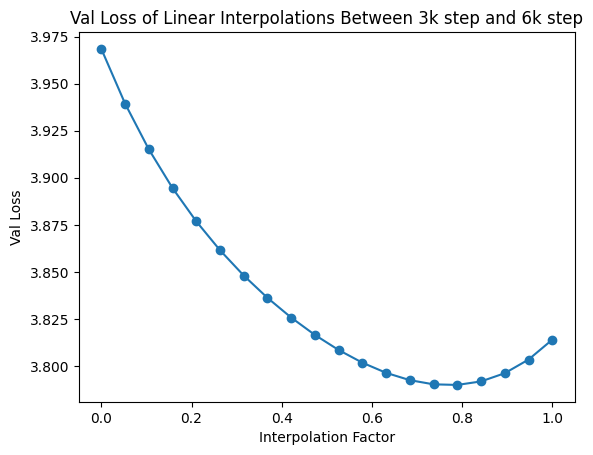

In [18]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 3k step and 6k step')
plt.show()

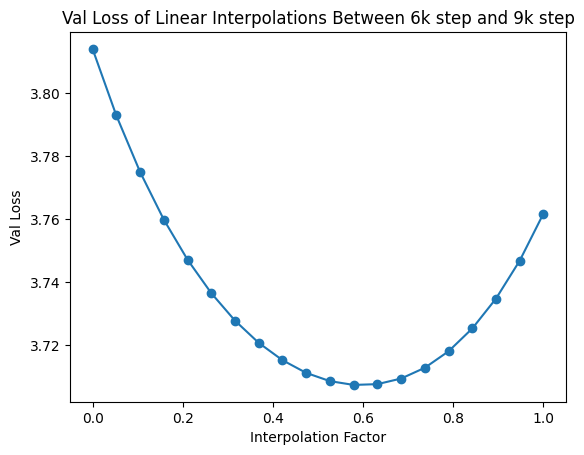

In [21]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 6k step and 9k step')
plt.show()

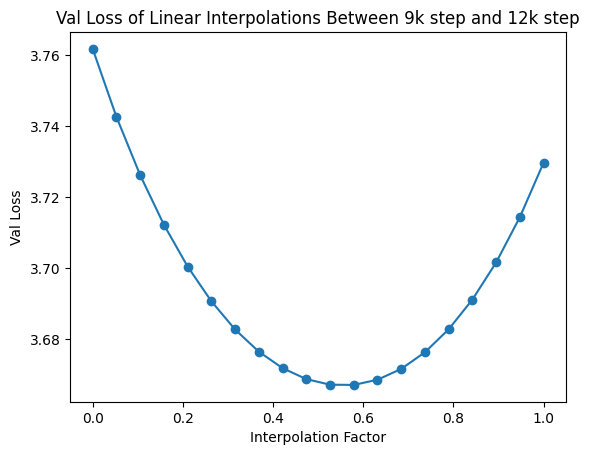

In [13]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 9k step and 12k step')
plt.show()

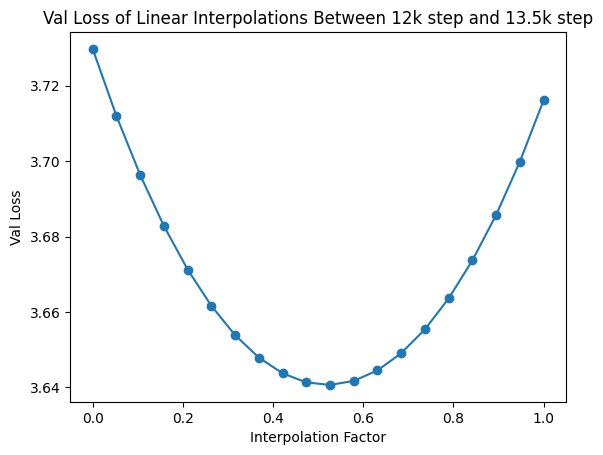

In [27]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 12k step and 13.5k step')
plt.show()

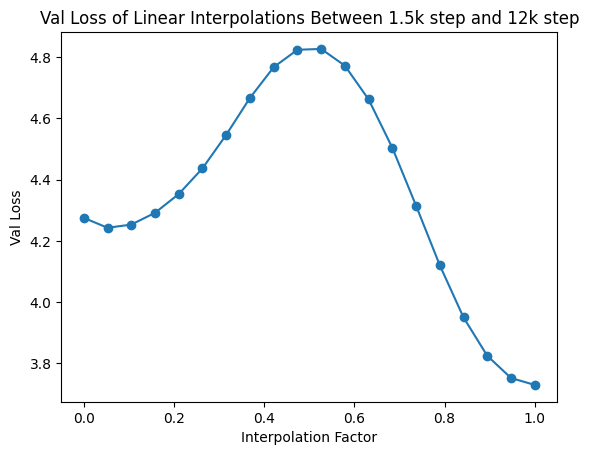

In [12]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 1.5k step and 12k step')
plt.show()

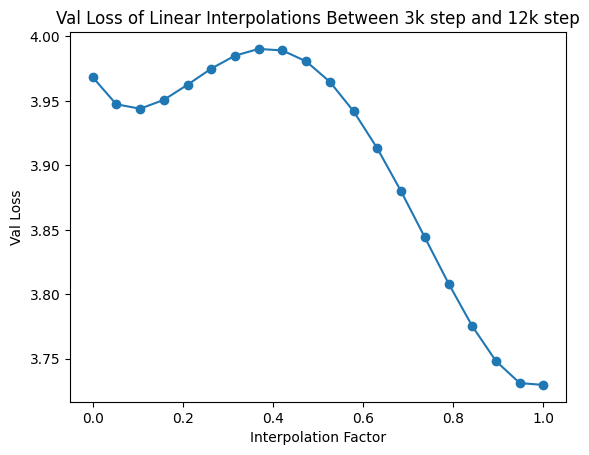

In [31]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 3k step and 12k step')
plt.show()

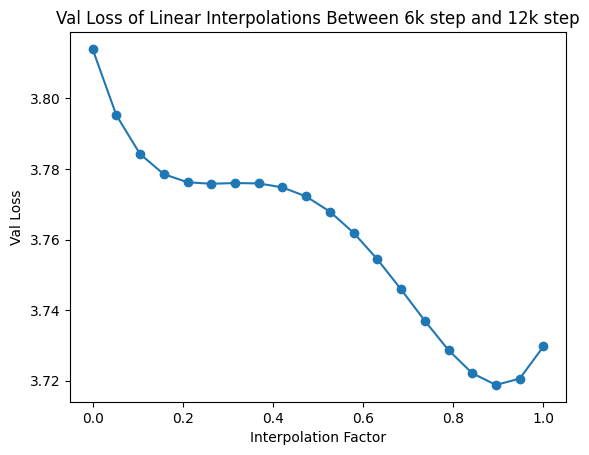

In [24]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 6k step and 12k step')
plt.show()

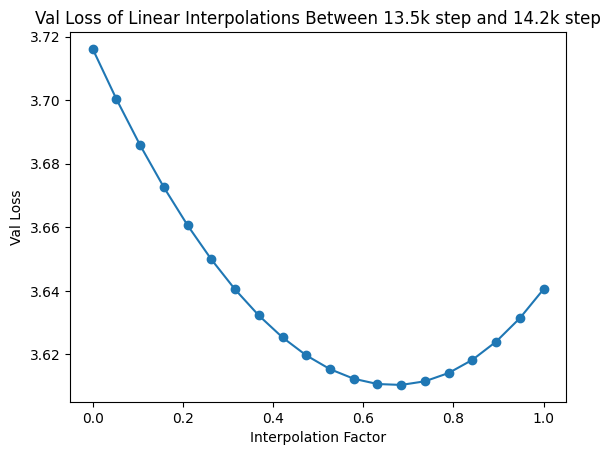

In [16]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 13.5k step and 14.2k step')
plt.show()

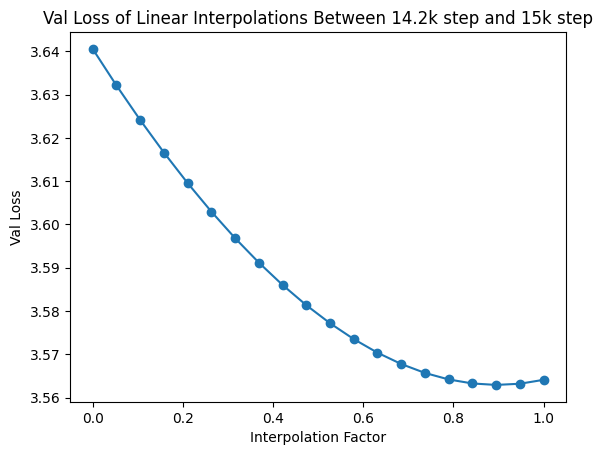

In [19]:
from matplotlib import pyplot as plt
plt.plot(interp_factors.numpy(), perplexities, marker='o')
plt.xlabel('Interpolation Factor')
plt.ylabel('Val Loss')
plt.title('Val Loss of Linear Interpolations Between 14.2k step and 15k step')
plt.show()

In [173]:

n_points = 20
lr_list = [1e-2,5e-3,2e-3,1e-3,5e-4,2e-4,1e-4, 5e-5,2e-5,1e-5]
perplexities = []

model = load_ck_state(model,15000).cuda()
model = distributed_backend.transform_model(model)
total_loss = 0
n_batches = 0
data = get_data_readers(args)
with torch.no_grad():
    for steps in range(10):
        x, y = get_batch(data["val"], device="cpu")
        x = x.cuda()
        y = y.cuda()
        print(f"  Processing batch {steps+1}...")
        outputs = model(x, targets=y, get_logits=True)
        total_loss += outputs["loss"].item()
        n_batches += 1
#interp_model = interp_model.cpu()
perplexity = torch.tensor(total_loss / n_batches)
perplexities.append(perplexity)

for lr in lr_list:
    
    distributed_backend = distributed.make_backend_from_args(args)
    args = distributed_backend.get_adjusted_args_for_process(args)
    model = load_ck_state(model,15000).cuda()
    model = distributed_backend.transform_model(model)
    group_specs = distributed_backend.get_raw_model(model).get_parameter_group_specs()
    group_specs = distributed_backend.get_raw_model(model).get_parameter_group_specs()
    param_name_mapping = {p_name: p for p_name, p in model.named_parameters()}
    optimized_params_cnt = 0
    for g in group_specs:
        params = []
        for p_name in g["params"]:
            translated_p_names = (
                distributed_backend.translate_model_parameter_name_for_node(p_name)
            )
            params += [param_name_mapping[p_name] for p_name in translated_p_names]
        g["params"] = params
        optimized_params_cnt += sum([p.numel() for p in g["params"]])
    opt = torch.optim.AdamW(
                group_specs,
                lr=args.lr,
                betas=(args.beta1, args.beta2),
                weight_decay=args.weight_decay,
            )
    
    current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/15000/main.pt",map_location=torch.device('cpu'))
    opt.load_state_dict(current_ckpt["optimizer"])
    
    lambda_schedule = wsd_schedule(
                    n_iterations=args.iterations,
                    n_warmup=args.warmup_steps,
                    fract_decay=args.wsd_fract_decay,
                    init_div_factor=1e2,
                    final_lr_factor=args.wsd_final_lr_scale,  # should be 0 here
                    decay_type=args.decay_type,
                )
    #scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lambda_schedule)
    for param_group in opt.param_groups:
        print("original lr: ", param_group['lr'])
        param_group['lr'] = lr
    model = model.cuda()
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    outputs = model(x_train, targets=y_train, get_logits=True)
    loss = outputs["loss"]
    loss.backward()
    opt.step()
    opt.zero_grad()

    total_loss = 0
    n_batches = 0
    data = get_data_readers(args)
    with torch.no_grad():
        for steps in range(10):
            x, y = get_batch(data["val"], device="cpu")
            x = x.cuda()
            y = y.cuda()
            print(f"  Processing batch {steps+1}...")
            outputs = model(x, targets=y, get_logits=True)
            total_loss += outputs["loss"].item()
            n_batches += 1

    #interp_model = interp_model.cpu()
    perplexity = torch.tensor(total_loss / n_batches)
    perplexities.append(perplexity)
    print(f"  for lr = {lr}, loss = {perplexity:.2f}")


/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
original lr:  0.0
original lr:  0.0
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  for lr = 0.01, loss = 4.47
original lr:  0.0
original lr:  0.0
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Proc

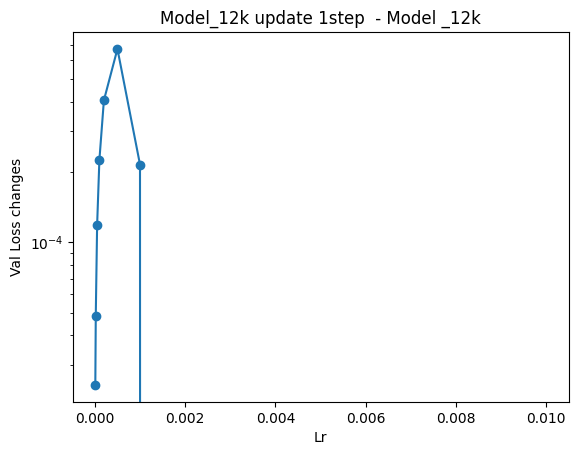

In [161]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.yscale("log")
plt.title('Model_12k update 1step  - Model _12k')
plt.show()

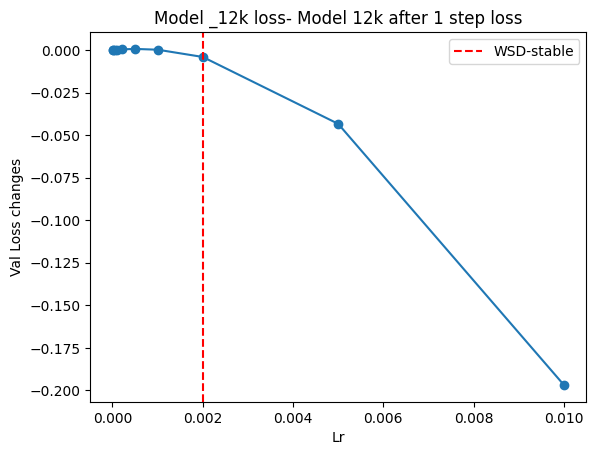

In [167]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.title('Model _12k loss- Model 12k after 1 step loss')
plt.axvline(x=0.002, color='red', linestyle='--', label='WSD-stable')
plt.legend()
plt.show()

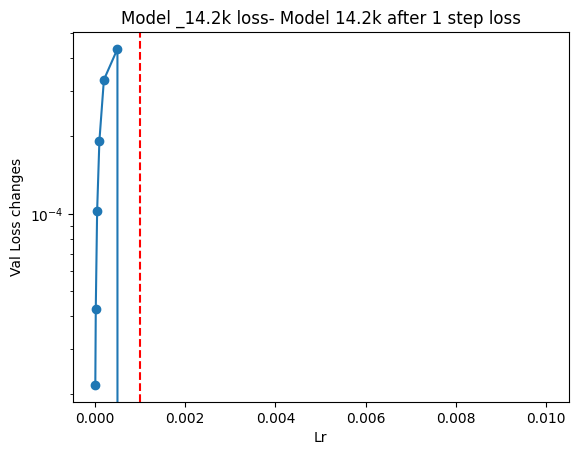

In [172]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.yscale("log")
plt.title('Model _14.2k loss- Model 14.2k after 1 step loss')
plt.axvline(x=0.001, color='red', linestyle='--', label='WSD-decay')
plt.show()

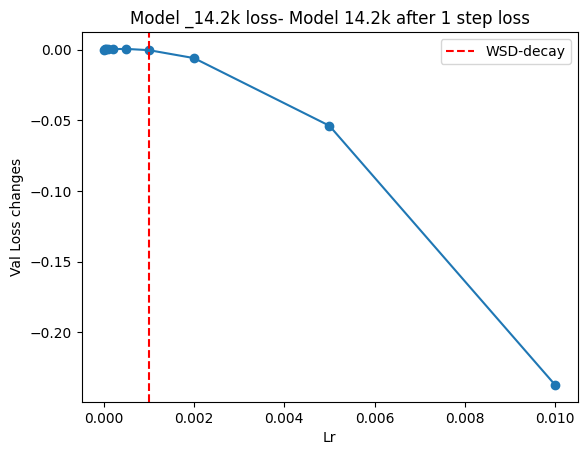

In [170]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.title('Model _14.2k loss- Model 14.2k after 1 step loss')
plt.axvline(x=0.001, color='red', linestyle='--', label='WSD-decay')
plt.legend()
plt.show()

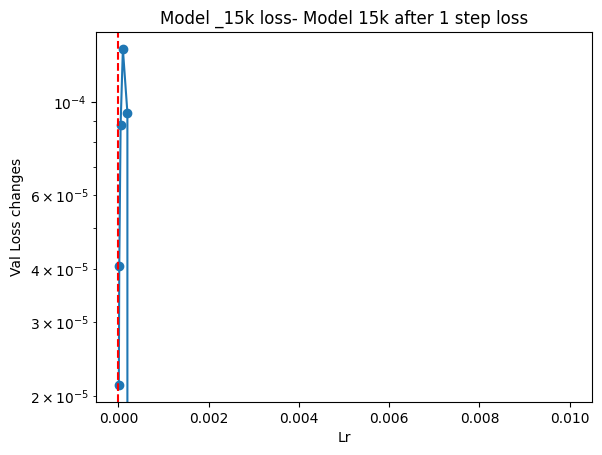

In [175]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.yscale("log")
plt.title('Model _15k loss- Model 15k after 1 step loss')
plt.axvline(x=0, color='red', linestyle='--', label='WSD-decay')
plt.show()

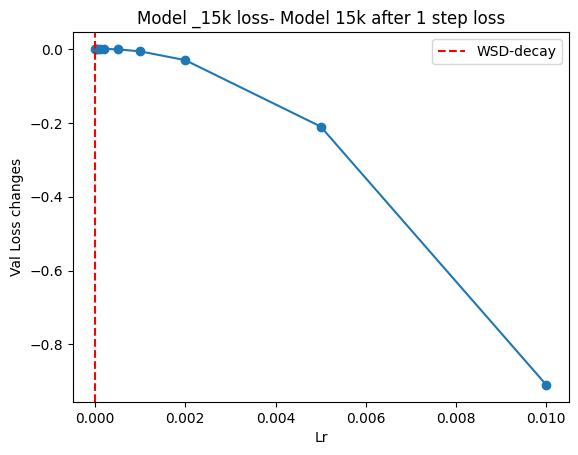

In [174]:
from matplotlib import pyplot as plt
plt.plot(lr_list, [(perplexities[0]-i) for i in perplexities[1:]], marker='o')
plt.xlabel('Lr')
plt.ylabel('Val Loss changes')
plt.title('Model _15k loss- Model 15k after 1 step loss')
plt.axvline(x=0, color='red', linestyle='--', label='WSD-decay')
plt.legend()
plt.show()

In [143]:
perplexities

[tensor(3.9265),
 tensor(3.7731),
 tensor(3.7338),
 tensor(3.7295),
 tensor(3.7291),
 tensor(3.7293),
 tensor(3.7295),
 tensor(3.7296),
 tensor(3.7297),
 tensor(3.7297)]

In [151]:
[(i-perplexities[0]) for i in perplexities[1:]]

[tensor(0.1968),
 tensor(0.0434),
 tensor(0.0041),
 tensor(-0.0002),
 tensor(-0.0007),
 tensor(-0.0004),
 tensor(-0.0002),
 tensor(-0.0001),
 tensor(-4.8637e-05),
 tensor(-2.4557e-05)]

In [157]:
perplexities

[tensor(3.7297),
 tensor(3.9265),
 tensor(3.7731),
 tensor(3.7338),
 tensor(3.7295),
 tensor(3.7291),
 tensor(3.7293),
 tensor(3.7295),
 tensor(3.7296),
 tensor(3.7297),
 tensor(3.7297)]

In [ ]:
model = load_ck_state(model,12000).cuda()
model = distributed_backend.transform_model(model)

In [141]:
lr_list[2]

0.002

In [108]:
model.state_dict()["lm_head.weight"][0,0]+=10

In [110]:
model.state_dict()["lm_head.weight"][0,0]

tensor(10.0258, device='cuda:0')

In [111]:
model.lm_head.weight

Parameter containing:
tensor([[ 1.0026e+01, -4.5661e-02, -1.6528e-01,  ...,  1.0528e-01,
          9.7907e-02,  1.4117e-01],
        [-2.1791e-01, -1.9246e-01, -2.6568e-02,  ..., -8.3810e-02,
         -3.6543e-03,  3.6610e-01],
        [-2.0365e-01,  1.9586e-02, -5.4140e-03,  ...,  1.3401e-01,
         -8.8467e-02, -3.8703e-02],
        ...,
        [ 4.8271e-02,  2.2489e-03,  5.9155e-02,  ...,  8.2831e-02,
          3.4447e-02, -1.5983e-01],
        [ 3.6189e-02, -8.7103e-04,  6.7963e-02,  ...,  8.9460e-02,
          3.0572e-02, -1.5727e-01],
        [ 3.2870e-02, -2.0442e-03,  6.6715e-02,  ...,  8.8982e-02,
          2.9523e-02, -1.5339e-01]], device='cuda:0', requires_grad=True)

In [93]:
before_opt = copy.deepcopy(opt)#

#for param_group in opt.param_groups:
#    print(param_group['params'])

In [96]:
for param_group in opt.param_groups:
    print(param_group['params'])

TypeError: 'AdamW' object is not subscriptable

In [53]:
original = model.lm_head.weight.clone()

In [124]:
args.opt

'adamw'

In [72]:
original_w1 = model.transformer.h[0].mlp.w1.weight

In [63]:
(original-model.lm_head.weight).max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [75]:
(original_w1 - model.transformer.h[0].mlp.w1.weight).max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [26]:
model.lm_head.weight.grad

tensor([[ 1.0580e-04,  3.6757e-05, -1.3199e-04,  ...,  1.8401e-04,
          1.7110e-04,  8.3289e-05],
        [-1.0851e-05,  2.4556e-05,  1.1582e-04,  ...,  2.4568e-05,
          2.7183e-05,  1.4420e-05],
        [-1.3744e-05,  2.8029e-05, -1.4194e-05,  ..., -5.4665e-06,
         -4.4328e-06,  2.3955e-05],
        ...,
        [-9.9585e-11, -2.1056e-11,  5.5094e-11,  ..., -2.3718e-11,
         -1.5729e-11, -7.6027e-11],
        [-1.0083e-10, -2.1117e-11,  5.8391e-11,  ..., -2.1353e-11,
         -1.6994e-11, -7.6458e-11],
        [-1.0067e-10, -2.1300e-11,  5.7462e-11,  ..., -2.2398e-11,
         -1.6051e-11, -7.6210e-11]], device='cuda:0')

In [40]:
opt.step()

In [127]:
model = load_ck_state(model,12000).cuda()
model = distributed_backend.transform_model(model)
group_specs = distributed_backend.get_raw_model(model).get_parameter_group_specs()
param_name_mapping = {p_name: p for p_name, p in model.named_parameters()}
optimized_params_cnt = 0
for g in group_specs:
    params = []
    for p_name in g["params"]:
        translated_p_names = (
            distributed_backend.translate_model_parameter_name_for_node(p_name)
        )
        params += [param_name_mapping[p_name] for p_name in translated_p_names]
    g["params"] = params
    optimized_params_cnt += sum([p.numel() for p in g["params"]])
opt = torch.optim.AdamW(
            group_specs,
            lr=args.lr,
            betas=(args.beta1, args.beta2),
            weight_decay=args.weight_decay,
        )

current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/12000/main.pt",map_location=torch.device('cpu'))
opt.load_state_dict(current_ckpt["optimizer"])

lambda_schedule = wsd_schedule(
                n_iterations=args.iterations,
                n_warmup=args.warmup_steps,
                fract_decay=args.wsd_fract_decay,
                init_div_factor=1e2,
                final_lr_factor=args.wsd_final_lr_scale,  # should be 0 here
                decay_type=args.decay_type,
            )
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lambda_schedule)
for param_group in opt.param_groups:
    param_group['lr'] = 1e-1
model = model.cuda()
x_train = x_train.cuda()
y_train = y_train.cuda()
outputs = model(x_train, targets=y_train, get_logits=True)
loss = outputs["loss"]
loss.backward()
opt.step()
##opt.zero_grad()

In [128]:
model3 = load_ck_state(model,12000).cuda()

In [130]:
model3.lm_head.weight

Parameter containing:
tensor([[ 0.0258, -0.0457, -0.1653,  ...,  0.1053,  0.0979,  0.1412],
        [-0.2179, -0.1925, -0.0266,  ..., -0.0838, -0.0037,  0.3661],
        [-0.2037,  0.0196, -0.0054,  ...,  0.1340, -0.0885, -0.0387],
        ...,
        [ 0.0483,  0.0022,  0.0592,  ...,  0.0828,  0.0344, -0.1598],
        [ 0.0362, -0.0009,  0.0680,  ...,  0.0895,  0.0306, -0.1573],
        [ 0.0329, -0.0020,  0.0667,  ...,  0.0890,  0.0295, -0.1534]],
       device='cuda:0', requires_grad=True)

In [131]:
model.lm_head.weight

Parameter containing:
tensor([[-6.0887e-03, -3.9082e-02, -1.5786e-01,  ...,  4.7364e-02,
          7.4345e-02,  1.4813e-01],
        [-1.8874e-01, -1.8526e-01, -3.4644e-02,  ..., -9.9495e-02,
          4.4844e-03,  3.8676e-01],
        [-1.7852e-01,  2.5576e-02,  9.4358e-04,  ...,  1.4111e-01,
         -7.5202e-02, -1.9893e-02],
        ...,
        [ 4.7964e-02,  2.7329e-03,  5.8930e-02,  ...,  8.2243e-02,
          3.4365e-02, -1.5860e-01],
        [ 3.5892e-02, -3.7864e-04,  6.7710e-02,  ...,  8.8842e-02,
          3.0502e-02, -1.5603e-01],
        [ 3.2576e-02, -1.5505e-03,  6.6468e-02,  ...,  8.8371e-02,
          2.9453e-02, -1.5215e-01]], device='cuda:0', requires_grad=True)

In [17]:
perplexities

[tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297),
 tensor(3.7297)]

In [76]:
current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/12000/main.pt",map_location=torch.device('cpu'))
opt.load_state_dict(current_ckpt["optimizer"])

In [77]:
lambda_schedule = wsd_schedule(
                n_iterations=args.iterations,
                n_warmup=args.warmup_steps,
                fract_decay=args.wsd_fract_decay,
                init_div_factor=1e2,
                final_lr_factor=args.wsd_final_lr_scale,  # should be 0 here
                decay_type=args.decay_type,
            )
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lambda_schedule)

In [78]:
scheduler.load_state_dict(current_ckpt['scheduler'])

In [72]:
scheduler.step()

In [122]:
model = model.cuda()
x = x.cuda()
y = y.cuda()
outputs = model(x, targets=y, get_logits=True)
loss = outputs["loss"]
loss.backward()
opt.step()
#opt.zero_grad()

In [73]:
for param_group in opt.param_groups:
    print(param_group['lr'])

0.002
0.002


In [64]:
[opt.state_dict()["state"][i]["exp_avg"].shape for i in range(58)]

[torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384, 1024]),
 torch.Size([1024, 3

In [53]:
[model.state_dict()[i].shape for i in model.state_dict().keys()]

[torch.Size([50304, 384]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([384, 1024]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([384, 1024]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([384, 1024]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([384, 1024]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size([1024, 384]),
 torch.Size([384, 1024]),
 torch.Size([384]),
 torch.Size([1152, 384]),
 torch.Size([384, 384]),
 torch.Size([384]),
 torch.Size([1024, 384]),
 torch.Size

In [41]:
opt.state_dict()["state"][0]

{'step': tensor(12003.),
 'exp_avg': tensor([[ 4.0107e-06, -4.2925e-06,  7.7124e-06,  ..., -7.1418e-07,
          -2.0169e-06,  2.1246e-06],
         [ 1.2697e-06, -9.7554e-08,  2.0076e-06,  ..., -1.5006e-06,
          -1.3768e-06,  1.7159e-06],
         [-1.4896e-06,  2.4884e-06, -5.2372e-06,  ...,  1.1722e-06,
           1.8140e-06, -1.2182e-06],
         ...,
         [-5.6764e-06,  7.0924e-05, -6.2000e-06,  ...,  3.3530e-05,
          -6.3269e-07, -1.0012e-05],
         [-1.2232e-05,  3.0335e-05,  2.8196e-05,  ..., -1.0185e-06,
          -5.0451e-06, -6.0384e-06],
         [ 9.8161e-06, -3.6035e-05,  7.9759e-06,  ...,  2.8005e-06,
          -4.7598e-07, -5.5403e-06]], device='cuda:0'),
 'exp_avg_sq': tensor([[3.5927e-11, 9.0056e-11, 3.3691e-11,  ..., 2.2154e-11, 6.5634e-12,
          6.4735e-11],
         [1.4255e-11, 6.5200e-11, 2.1948e-11,  ..., 2.1657e-11, 9.6980e-12,
          5.9258e-11],
         [6.8806e-12, 2.7114e-11, 1.5679e-11,  ..., 9.8655e-12, 3.0472e-12,
          4.9

In [9]:
import torch.nn.functional as F
ckpt_list = [0,100,300,900,1500,3000,6000,9000,12000,13500,14250,15000]
w_norm_collect =[]
v_collect = []
logit_collect = []
for i in range(len(ckpt_list)):
    current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{ckpt_list[i]}/main.pt",map_location=torch.device('cpu'))
    
    new_state_dict = {}
    for key, value in current_ckpt["model"].items():
        new_key = key.replace('_orig_mod.', '')  # 移除前缀
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model_weight_norm = []
    for z in model.parameters():
        model_weight_norm.append(torch.norm(z)**2)
    model_weight_norm.append(torch.norm(model.lm_head.weight)**2)
    w_norm_collect.append(model_weight_norm)

    v_norm = []
    for z in range(len(current_ckpt["optimizer"]["state"])):
        v_norm.append(torch.norm(current_ckpt["optimizer"]["state"][z]["exp_avg_sq"])**2)
    v_collect.append(v_norm)

    outputs = model(x, targets=y, get_logits=True)
    print(f"for step {ckpt_list[i]}, logits is: ", F.softmax(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, logits is: ", torch.norm(outputs["logits"][0,:,:], dim=-1))
    logit_collect.append(torch.norm(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, loss is: ", outputs["loss"])

for step 0, logits is:  tensor([[2.7410e-05, 1.7884e-05, 4.1139e-05,  ..., 2.4227e-05, 1.5727e-05,
         2.4389e-05],
        [3.0372e-05, 1.8439e-05, 3.4815e-05,  ..., 3.0668e-05, 1.2678e-05,
         2.4830e-05],
        [2.4601e-05, 2.1545e-05, 4.0151e-05,  ..., 2.4984e-05, 1.1421e-05,
         2.7087e-05],
        ...,
        [3.4903e-05, 1.8155e-05, 1.7377e-05,  ..., 1.4580e-05, 2.2837e-05,
         2.3949e-05],
        [1.7238e-05, 1.7467e-05, 2.2741e-05,  ..., 1.4490e-05, 3.1175e-05,
         1.9585e-05],
        [1.6384e-05, 2.0149e-05, 2.4723e-05,  ..., 1.5199e-05, 3.0499e-05,
         2.5895e-05]], grad_fn=<SoftmaxBackward0>)
for step 0, logits is:  tensor([88.0662, 87.5828, 87.5337, 87.3946, 87.5565, 87.7825, 87.6164, 87.5634,
        87.5097, 87.8663, 87.6542, 87.7443, 87.7915, 87.8894, 87.8965, 87.7859,
        87.9051, 87.7130, 87.9511, 87.8006, 87.8904, 87.7043, 87.9732, 87.8106,
        87.9642, 87.9899, 87.8121, 87.9318, 88.2800, 87.6485, 88.0335, 87.8102,
        

In [75]:
x, y = get_batch(data["val"], device="cpu")
#outputs = model(x, targets=y, get_logits=True)

In [88]:
import torch.nn.functional as F
F.softmax(outputs["logits"], dim=-1)

tensor([[[1.4182e-04, 2.0143e-02, 5.1584e-03,  ..., 2.3922e-09,
          2.4639e-09, 2.5268e-09],
         [7.5259e-07, 5.7496e-08, 7.2681e-07,  ..., 3.5695e-09,
          3.5798e-09, 3.5295e-09],
         [1.1424e-07, 3.7193e-08, 1.0292e-07,  ..., 7.3888e-10,
          8.0217e-10, 7.7085e-10],
         ...,
         [9.0310e-05, 1.0836e-06, 3.3114e-07,  ..., 2.3105e-09,
          2.4500e-09, 2.3787e-09],
         [2.1500e-05, 9.3098e-08, 1.5636e-06,  ..., 8.0264e-10,
          7.7911e-10, 8.1104e-10],
         [3.3998e-02, 4.8093e-05, 3.7853e-06,  ..., 1.7680e-10,
          1.5927e-10, 1.7048e-10]],

        [[3.1804e-04, 5.0189e-04, 7.1118e-06,  ..., 3.3506e-09,
          3.2624e-09, 3.2419e-09],
         [1.4177e-05, 2.8259e-05, 9.0759e-07,  ..., 1.9377e-08,
          1.9363e-08, 1.9928e-08],
         [2.5425e-03, 1.9589e-03, 9.1875e-07,  ..., 1.2084e-09,
          1.2310e-09, 1.1925e-09],
         ...,
         [3.4397e-06, 4.0269e-06, 7.6405e-07,  ..., 6.1740e-09,
          6.103

tensor([[  198,   220,   220,  ...,   287,   262,  1956],
        [  319,   262,  1080,  ...,    11, 27635,    11],
        [ 1989,    11,   355,  ...,   761,   284,  1414],
        ...,
        [  290, 15995,  8821,  ...,   284,  8006,   351],
        [ 7464,   290,   262,  ..., 32350,   416,  1793],
        [ 2836,  7071,   290,  ...,   373,  6655,   379]])

In [36]:
v_collect = torch.tensor(v_collect[1:])

In [28]:
torch.norm(current_ckpt["optimizer"]["state"][3]["exp_avg_sq"])**2

tensor(2.4767e-11)

In [42]:
w_norm_collect = torch.tensor(w_norm_collect)
v_collect = torch.tensor(v_collect)

/tmp/ipykernel_2953609/3997711065.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_collect = torch.tensor(v_collect)


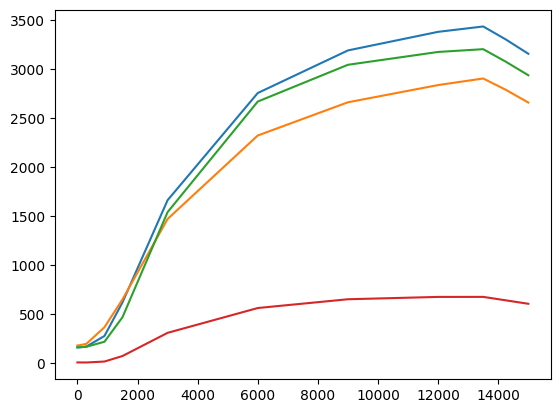

In [52]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot(ckpt_list,w_norm_collect[:,40],label="0")
plt.plot(ckpt_list,w_norm_collect[:,30],label="0")
plt.plot(ckpt_list,w_norm_collect[:,20],label="0")
plt.plot(ckpt_list,w_norm_collect[:,10],label="0")
#plt.yscale("log")
plt.show()

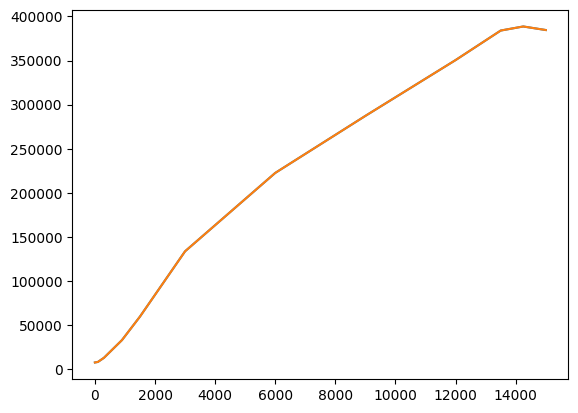

In [55]:
plt.plot(ckpt_list,w_norm_collect[:,-1],label="0")
plt.plot(ckpt_list,w_norm_collect[:,0],label="1")

tensor(7709.9512)

In [62]:
w_norm_collect[-1,-1]

tensor(384608.3750)

In [59]:
model.lm_head.weight

Parameter containing:
tensor([[ 0.0043, -0.0641, -0.1759,  ...,  0.1111,  0.1219,  0.1505],
        [-0.2183, -0.2114, -0.0254,  ..., -0.0847, -0.0113,  0.3778],
        [-0.2328, -0.0040,  0.0153,  ...,  0.1681, -0.1120, -0.0272],
        ...,
        [ 0.0419, -0.0125,  0.0464,  ...,  0.0769,  0.0128, -0.1543],
        [ 0.0303, -0.0160,  0.0545,  ...,  0.0826,  0.0090, -0.1510],
        [ 0.0271, -0.0170,  0.0534,  ...,  0.0826,  0.0077, -0.1486]],
       requires_grad=True)

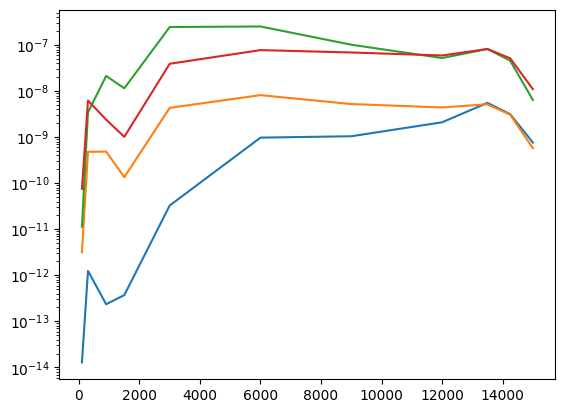

In [48]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")
plt.plot(ckpt_list[1:],v_collect[:,40],label="0")
plt.plot(ckpt_list[1:],v_collect[:,30],label="0")
plt.plot(ckpt_list[1:],v_collect[:,20],label="0")
plt.plot(ckpt_list[1:],v_collect[:,10],label="0")
plt.yscale("log")
plt.show()

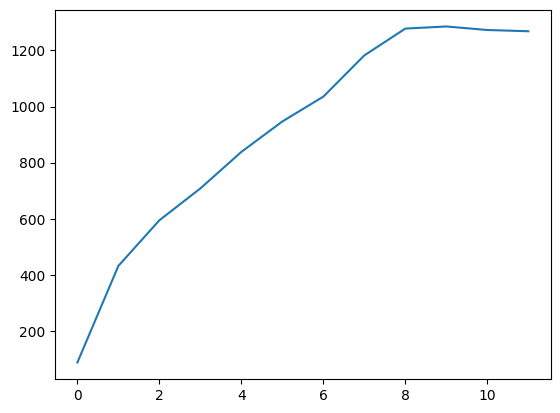

In [12]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.mean(i).detach().cpu().float() for i in logit_collect])
plt.show()

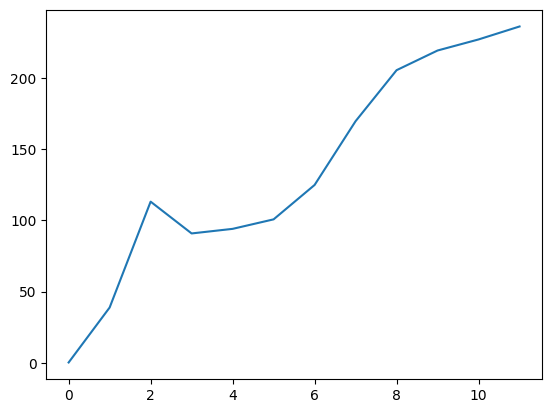

In [13]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.std(i).detach().cpu().float() for i in logit_collect])
plt.show()

In [28]:
torch.mean(logit_collect[0].cpu().detach()).float()

tensor(7679.3281)

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x15545188c860> (for post_run_cell), with arguments args (<ExecutionResult object at 15545e150e10, execution_count=28 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 15545e13f890, raw_cell="torch.mean(logit_collect[0].cpu().detach()).float(.." store_history=True silent=False shell_futures=True cell_id=2b7aaf5a-dcb9-4a1f-9bde-e919459ffd06> result=tensor(7679.3281)>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [12]:
ckpt= torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/9000/main.pt", map_location=torch.device('cpu'))

In [14]:
model.load_state_dict(ckpt)

RuntimeError: Error(s) in loading state_dict for Llama:
	Missing key(s) in state_dict: "transformer.wte.weight", "transformer.h.0.ln_1.weight", "transformer.h.0.attn.c_attn.weight", "transformer.h.0.attn.c_proj.weight", "transformer.h.0.ln_2.weight", "transformer.h.0.mlp.w1.weight", "transformer.h.0.mlp.w2.weight", "transformer.h.0.mlp.c_proj.weight", "transformer.h.1.ln_1.weight", "transformer.h.1.attn.c_attn.weight", "transformer.h.1.attn.c_proj.weight", "transformer.h.1.ln_2.weight", "transformer.h.1.mlp.w1.weight", "transformer.h.1.mlp.w2.weight", "transformer.h.1.mlp.c_proj.weight", "transformer.h.2.ln_1.weight", "transformer.h.2.attn.c_attn.weight", "transformer.h.2.attn.c_proj.weight", "transformer.h.2.ln_2.weight", "transformer.h.2.mlp.w1.weight", "transformer.h.2.mlp.w2.weight", "transformer.h.2.mlp.c_proj.weight", "transformer.h.3.ln_1.weight", "transformer.h.3.attn.c_attn.weight", "transformer.h.3.attn.c_proj.weight", "transformer.h.3.ln_2.weight", "transformer.h.3.mlp.w1.weight", "transformer.h.3.mlp.w2.weight", "transformer.h.3.mlp.c_proj.weight", "transformer.h.4.ln_1.weight", "transformer.h.4.attn.c_attn.weight", "transformer.h.4.attn.c_proj.weight", "transformer.h.4.ln_2.weight", "transformer.h.4.mlp.w1.weight", "transformer.h.4.mlp.w2.weight", "transformer.h.4.mlp.c_proj.weight", "transformer.h.5.ln_1.weight", "transformer.h.5.attn.c_attn.weight", "transformer.h.5.attn.c_proj.weight", "transformer.h.5.ln_2.weight", "transformer.h.5.mlp.w1.weight", "transformer.h.5.mlp.w2.weight", "transformer.h.5.mlp.c_proj.weight", "transformer.h.6.ln_1.weight", "transformer.h.6.attn.c_attn.weight", "transformer.h.6.attn.c_proj.weight", "transformer.h.6.ln_2.weight", "transformer.h.6.mlp.w1.weight", "transformer.h.6.mlp.w2.weight", "transformer.h.6.mlp.c_proj.weight", "transformer.h.7.ln_1.weight", "transformer.h.7.attn.c_attn.weight", "transformer.h.7.attn.c_proj.weight", "transformer.h.7.ln_2.weight", "transformer.h.7.mlp.w1.weight", "transformer.h.7.mlp.w2.weight", "transformer.h.7.mlp.c_proj.weight", "transformer.ln_f.weight", "lm_head.weight". 
	Unexpected key(s) in state_dict: "model", "optimizer", "scheduler", "itr". 

In [32]:
len(ckpt["optimizer"]["state"])
#[0]["exp_avg_sq"]

58

In [18]:
ckpt["model"]

OrderedDict([('_orig_mod.transformer.wte.weight',
              tensor([[ 0.0380, -0.0416, -0.1583,  ...,  0.0875,  0.1105,  0.1353],
                      [-0.1869, -0.1619, -0.0191,  ..., -0.0474, -0.0114,  0.3042],
                      [-0.1679,  0.0023,  0.0321,  ...,  0.0980, -0.1377, -0.0164],
                      ...,
                      [ 0.0686,  0.0264,  0.0315,  ...,  0.0914,  0.0550, -0.1859],
                      [ 0.0550,  0.0226,  0.0417,  ...,  0.0992,  0.0517, -0.1839],
                      [ 0.0521,  0.0226,  0.0393,  ...,  0.0985,  0.0499, -0.1796]])),
             ('_orig_mod.transformer.h.0.ln_1.weight',
              tensor([0.0771, 0.1140, 0.0732, 0.0778, 0.1468, 0.0677, 0.0819, 0.0725, 0.1877,
                      0.0624, 0.0599, 0.0842, 0.0735, 0.2298, 0.0524, 0.1138, 0.0569, 0.0774,
                      0.1038, 0.0722, 0.0657, 0.0549, 0.0806, 0.0530, 0.0609, 0.0564, 0.1025,
                      0.1490, 0.0783, 0.0676, 0.0576, 0.1265, 0.0792, 0.0619, 0

In [21]:
z = 0
for i in model.parameters():
    z+=1
z

58

In [26]:
for n,p in model.named_parameters():
    print(n)

transformer.wte.weight
transformer.h.0.ln_1.weight
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_proj.weight
transformer.h.0.ln_2.weight
transformer.h.0.mlp.w1.weight
transformer.h.0.mlp.w2.weight
transformer.h.0.mlp.c_proj.weight
transformer.h.1.ln_1.weight
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_proj.weight
transformer.h.1.ln_2.weight
transformer.h.1.mlp.w1.weight
transformer.h.1.mlp.w2.weight
transformer.h.1.mlp.c_proj.weight
transformer.h.2.ln_1.weight
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_proj.weight
transformer.h.2.ln_2.weight
transformer.h.2.mlp.w1.weight
transformer.h.2.mlp.w2.weight
transformer.h.2.mlp.c_proj.weight
transformer.h.3.ln_1.weight
transformer.h.3.attn.c_attn.weight
transformer.h.3.attn.c_proj.weight
transformer.h.3.ln_2.weight
transformer.h.3.mlp.w1.weight
transformer.h.3.mlp.w2.weight
transformer.h.3.mlp.c_proj.weight
transformer.h.4.ln_1.weight
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_proj.weight